# **Programming for Data Science Project, Group 18: NOVA IMS Teachers**

* 20231738 Abdul Rehman Khan
* 20231618 Antónia Negrão de Barros Lemos
* 20231726 Carolina Pon Nunes Lee Chin
* 20231687 Matilde Batista Pereira Martins Maximiano
* 20230012 Srijan dahal

This notebook was designed to address the objectives of the NOVA IMS Teachers Project, which aimed to reconstruct a web scraping pipeline for retrieving data about teaching staff at NOVA IMS found on the Nova IMS website, and later performing meaningful analysis on the dataset.

After the sudden loss of the original web scraping pipeline, our goal is to rebuild it, analyze the provided dataset, and generate actionable insights. The project is divided into three main objectives, which we will tackle systematically: Web Scraping, Data Wrangling and Analysis, and Data Science in Action.

---

*Importing the libraries we will work with:*

In [ ]:
pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 20.8 MB/s eta 0:00:00


In [ ]:
pip install matplotlib_venn

In [ ]:
import math
import numpy as np
import pandas as pd
import difflib

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
sns.set_style('dark')
import plotly.express as px
import plotly.graph_objects as go

import spacy
from wordcloud import WordCloud
import networkx as nx

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import classification_report

from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram, linkage

from itertools import combinations

import torch #LETS SEEEEEEE
import shap #SMAMEMEMME

import time
import re

from bs4 import BeautifulSoup
import requests

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import (
    TimeoutException,
    NoSuchElementException,
    ElementClickInterceptedException,
    StaleElementReferenceException
)

import warnings
warnings.filterwarnings('ignore')


#Web Scraping:

*For the first step of our webscraping task, we will be creating a function to extract, from an HTML page, the links to the professor's personal information pages. This process will involve parsing the HTML and thereby locating specific elements that contain each link. Once these elements are identified, we'll extract the URLS using a regular expression, which will finally allow us to group all links together in order to properly work with them in the next steps.*

In [ ]:
def get_prof_links(soupObj): # defining the function to extract professor links
    get_prof_links= soupObj.find_all(class_ = 'card-avatar__link arrow-animate', attrs='href') # finding all elements with the specified class and href attribute containing professor links
    # the class card-avatar__link arrow-animate represents the clickable avatar/ profile link for each professor
    prof_links= [re.search(r'href="([^"]*)"', str(link)).group(1) for link in get_prof_links] # extracting the 'href' attribute (URL) from each element using regular expression
    return prof_links # returns the list of the extracted professor links

*In this step, we will develop a function to process a list of professors' personal page links in order to extract key information from each page. For each professor, the function will retrieve and organize data into a dataframe, which will include the professor's name, title, courses, publications, and biography.*

In [ ]:
def get_page_df(prof_links):

    """
    Does: Extracts information from each link in the list of professors' personal links
    - Name, Title, Taught courses, Number of Publications, Biography
    Input: list of professors' personal links in a given page
    Output: 5-column Dataframe containing information on all professors' in a given page
    """
    # Getting beautiful soup
    page_df = pd.DataFrame() # initializing an empty DataFrame to store all professors' information

    for link in prof_links: # iterating over each professor's personal link in the list
        prof_df =  pd.DataFrame()  # initializing an empty DataFrame to store the current professor's data

        html_source= requests.get(link) # sending an HTTP GET request to fetch the HTML content of the professor's page
        soupObj = BeautifulSoup(html_source.text, 'html.parser') # parsing the HTML with BeautifulSoup
        main_grid = soupObj.body.find(class_ = "card-avatar__wrap") # finding the main container of the professor's profile information

        clean_name = main_grid.find(class_ ="card-avatar__heading gamma").text # extracting the professor's name from the specified class

        clean_title = main_grid.find(class_ = "card-avatar__posheading").text # extracting the professor's title from the specified class

        courses_= main_grid.find_all(class_="card-avatar__list-item") # finding all course listings from the professor's page
        course_list= [course.text.strip() for course in courses_] # extracting the text of each course listed
        clean_courses= ', '.join(course_list) # joining the courses' text in a single string for each professor

        publications_lis= soupObj.find_all(class_="search-results__posheading") # finding all publication entries on the professor's page
        publications =[i.text for i in publications_lis if i.text!=''] # extracting the publication titles and ignoring empty ones
        clean_len_publications = len(publications) # coutning the number of publications listed

        clean_biography = soupObj.find(class_="content__copy").text # extracting the professor's biography from the specified class
        prof_df =  pd.DataFrame([clean_name, clean_title, clean_courses, clean_len_publications, clean_biography]).T # storing the professor's data in a DataFrame (and transposing for proper format)

        page_df = pd.concat([page_df, prof_df], ignore_index = True) # appending the current professor's data to the main DataFrame

    return page_df # returning the complete DataFrame with all professors' information


In this next step, a function to help the program navigate through multiple pages on a website by clicking the "Next Page" button will be created, which will automate the process of moving from one page to the next, allowing for continuous scraping or interaction with the website.


The process will begin by waiting for any initial elements to appear, such as a cookie acceptance prompt. If the prompt is present, the function will automatically accept the cookies to proceed.

Then, it checks for the "Next Page" button, which allows the program to go to the next page of content. Depending on which page the program is on, the button’s appearance might change slightly, so the function handles both cases by looking for different patterns.

Once the button is found and ready to be clicked, the program scrolls the page to bring it into view and clicks it. If the click is blocked for any reason, the program uses an alternative method to click the button directly using JavaScript. After the click, the program pauses to give the website time to load the next page before continuing.

This function ensures smooth navigation between pages, making the web scraping or interaction process more efficient and reliable.


Finally, the updated driver instance is returned, ready to continue interacting with the next page.

This approach ensures the web scraping process continues smoothly across multiple pages, handling potential issues like cookies or animations, and interacting with the page in a way that mimics real user behavior.


This function helps the program move to the next page on a website. It automatically clicks the "Next Page" button to load more content, just like a person would do by clicking it manually.

The process starts by checking if there are any pop-ups, like cookie acceptance messages, and closes them if needed. Then, it looks for the "Next Page" button. Once found, it clicks the button to load the next page. If there’s an issue clicking it, the program tries again using a different method.

In short, this function makes sure the program can keep moving through pages without needing anyone to click the buttons themselves.


In [ ]:
def click_next_page_button(driver, iteration):
    """
    Does:Clicks the next page button and returns the updated driver.

    Input: driver- (webdriver) as Selenium webdriver instance; and iteration number for technical purposes
    Output: driver- The updated Selenium webdriver instance.

    Note: time.sleep instances allow for better driver processing
    """
    print(f'Initializing transition for page {iteration +1}')
    try:
        wait = WebDriverWait(driver, 10) # initializing a wait object to wait for elements with a timeout of 10 seconds
        print('1. driver intial waiting') # printing a message indicating the driver is waiting
        # optionally accept cookies or pass it of element is found
        try:
            accept_cookies = wait.until(EC.element_to_be_clickable((By.XPATH, '//button[text()="Accept All Cookies"]'))) # waiting for the "Accept All Cookies" button to be clickable
            accept_cookies.click()  # clicking the "Accept All Cookies" button
            time.sleep(5)  # pausing for 5 seconds after accepting cookies
            print('driver getting cookies')
        except (TimeoutException, NoSuchElementException): # moving on without error if the cookies banner isn’t found
            pass  # in case cookies banner is present

        # waiting until the pagination button is visible and clickable
        if iteration ==1 :
            button_xpath = "//button[@class='pagination__button pagination__button--next' and @aria-label='Página Seguinte']" # XPath for the "Next Page" button on the first page
        else:
            button_xpath = "//button[@class='pagination__button pagination__button--next is-active' and @aria-label='Página Seguinte']" # XPath for the "Next Page" button after the first page
        print('2. driver button visible')

        button = wait.until(EC.visibility_of_element_located((By.XPATH, button_xpath))) # waiting for the button to be visible on the page
        button = wait.until(EC.element_to_be_clickable((By.XPATH, button_xpath))) # waiting for the button to be clickable

        driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", button) # scrolling to the button

        time.sleep(10) # pausing for 10 seconds to allow any animations or transitions to complete
        print('3. driver waiting')

        try: # attempting to click the button
            button.click() # clicking the next page button
            time.sleep(10)  # pausing for 10 seconds after the click to allow page to load
            print('alternate: driver sleeping')


        except ElementClickInterceptedException: # if the click is still intercepted, try using JavaScript
            driver.execute_script("arguments[0].click();", button) # using JavaScript to click the button directly
            time.sleep(10)  # pausing for 10 seconds after the JS click

        return driver # returning the updated driver after the page transition

    except Exception as e: # catching any exceptions that occur during the process
        print(f"An error occurred: {e}") # printing an error message if something goes wrong
        return driver # returning the driver even if an error occurs to avoid stopping the program

In this step, the program opens a website and prepares to interact with it.

First, it opens the website using a web browser controlled by the program (Chrome in this case). It then disables any cookies by deleting them to avoid pop-ups interfering with the process. After the page loads, the program grabs the HTML content of the page.

Next, the program uses a tool called BeautifulSoup to analyze the HTML and understand the layout of the page. It looks for the "Next Page" buttons to figure out how many pages of content there are to go through. The program counts the total number of buttons and prints how many iterations (pages) it will need to process.

This setup prepares the program to navigate through the pages and collect the necessary information from each one.


In [ ]:
driver = webdriver.Chrome() # initializing the Chrome web driver to control the browser
url = 'https://www.novaims.unl.pt/en/nova-ims/teaching-staff/' # specifiying which URL to open
driver.get(url) # opening the specified URL in the browser
driver.delete_all_cookies() # disabling cookies to avoid cookie pop ups
html_source = driver.page_source #retrieving the HTML source of the page that was loaded in the browser


# getting overallinformation on the buttons to understand number of iterations
soupObj1 = BeautifulSoup(html_source, 'html.parser') # parsing the HTML content using BeautifulSoup
getting_buttons= soupObj1.find_all('button', class_ = "pagination__item-button") # finding all buttons for pagination
buttons = [button for button in getting_buttons] # creating list of all the pagination buttons found

print(f'Performing {len(buttons) -1} iterations for {len(buttons)} buttons.') # prints number of pages to iterate through

In this step, the program collects data from multiple pages of a website, extracting information about professors.

First, it sets up an empty table (a DataFrame) to store the data. The program then loops through each page of the website, based on the number of "Next Page" buttons available.

For each page, the program grabs the page's HTML content and extracts the links to individual professor pages. It then collects detailed information about the professors from those pages and adds it to the main table.

After collecting data from the current page, the program moves to the next page by clicking the "Next Page" button. If it can't go to the next page or if something goes wrong, it stops and prints an error message.

In summary, this process allows the program to gather data from multiple pages without manual intervention, moving from page to page and compiling the information into a single table.


In [ ]:
df= pd.DataFrame() # initializing a data frame

In [ ]:
# coming from existing driver
for iteration in range(1, len(buttons)+1): # looping through each page, iterating based on the number of pagination buttons
    if driver is None: # checking if the driver is None
        print("Error: driver is None") # printing an error message if the driver is not initialised
        break # breaking the loop if the driver is None

    html_page = driver.page_source # retrieving the HTML source code of the current page from the browser

    # data extraction
    soup_page = BeautifulSoup(html_page, 'html.parser') # parsing the HTML content with BeautifulSoup
    prof_links = get_prof_links(soup_page) # prof link extraction
    page_df = get_page_df(prof_links) # getting a DataFrame containing information about professors from the links
    df = pd.concat([df, page_df], ignore_index=True) # appending the extracted data to the main dataframe

    if iteration < len(buttons): # checking if there are any more pages to navigate to
        driver= click_next_page_button(driver, iteration) # updating driver
        if driver is None: # if the driver is None after clicking the button, printing an error message and stopping the process
            print(f"Failed to navigate to page {iteration + 1}. Stopping.")
            break

In this step, the program prepares the collected data for saving into a CSV file.

First, it renames the columns in the data table to make them more readable, such as changing column names to "Name", "Title", "Courses", "Publications", and "Biography".

Then, it ensures that each column has the correct data type for better handling. For example, it ensures that "Publications" is treated as a number and "Name", "Courses", and "Biography" are treated as text.

The program also cleans up the data by removing any unwanted characters, such as carriage return (`\r`) symbols, from the "Title" column.

Finally, the cleaned data is ready for further use or saving into a CSV file.


In [ ]:
# saving the csv file
df= df.set_axis(['Name', 'Title', 'Courses', 'Publications', 'Biography'], axis = 1) # renaming the columns of the dataframe

dtypes_ = {'Name': 'object', 'Courses': 'object', 'Publications': 'int64', 'Biography': 'object'} # defining the data types for each column
df= df.astype(dtypes_) # changing the data type of each column into the defined ones
def remove_rstr(row): # defining a function to remove carriage return characters (\r)
    return row.replace('\r','') # replacing carriage return characters with nothing

df['Title'] = df['Title'].apply(remove_rstr) # applying the remove_rstr function to the 'Title' column to clean the data
df

Now that the CSV file is saved, let's import it, as well as the given CSV.

In [ ]:
dataset_w = pd.read_csv("Final Webscrap.csv") # importing the result of the webscraper

In [ ]:
dataset_p = pd.read_csv("nova_ims_teaching_staff_2024-12-20.csv") # importing the dataset given by the teacher

`Checking dataset similarities`

In [ ]:
scraped_df = dataset_w.copy()  # creating a copy of the dataset_w
given_df = dataset_p.copy()  # creating a copy of the dataset_p

similarity = (scraped_df == given_df).sum().sum() / scraped_df.size  # comparing the two DataFrames element by element, counting the matches, and dividing by total size to get the similarity ratio

print(f"Similarity: {similarity * 100:.2f}%")  # printing the similarity percentage between the two DataFrames, formatted to two decimal places

Similarity: 98.53%


*As we can see in the similarity score, the datasets almost completely match. We found, trough hands-on exploration of the csv file, that the main difference between them is that some nan values are different, because one of them is in numpy (treats them as a float value) and the other one is in pandas(empty value). To have the datasets look the exact same, we are going to write a code that will standardize the text, removing unwanted characters and new lines/strip spacing; compare the datasets row by row and column by column, to adress NaN value differences; update the dataframes and check if all differences have been adressed.*

In [ ]:
# ensuring both DataFrames have the same structure (column order, names, etc.)
assert list(scraped_df.columns) == list(given_df.columns), "Columns do not match!"

# defining a function to clean text values by removing unwanted characters and formatting
def clean_text(text):
    if isinstance(text, str):  # only cleaning the text if the value is a string
        return text.replace('\n', ' ').strip()  # replacing newline characters with space and removing surrounding spaces
    return text  # returning the value unchanged if it's not a string

# applying the `clean_text` function to every element in the `scraped_df` DataFrame
scraped_df = scraped_df.applymap(clean_text)

# initializing a list to store details of all differences found between the two DataFrames
differences = []

# iterating through each row and column to compare values in the two DataFrames
for index in range(len(scraped_df)):  # looping through each row by its index
    for col in scraped_df.columns:  # looping through each column in the DataFrame
        scraped_value = scraped_df.at[index, col]  # getting the value from the scraped DataFrame
        given_value = given_df.at[index, col]      # getting the value from the given DataFrame

        # handling NaN (missing) values, treating them as equal if both are NaN
        if pd.isna(scraped_value) and pd.isna(given_value):
            continue  # skipping to the next iteration if both are NaN
        elif scraped_value != given_value:  # checking if the values are different
            # recording the difference in a dictionary and adding it to the list
            diff = {
                'Row': index,              # row index of the difference
                'Column': col,             # column name of the difference
                'Scraped Value': scraped_value,  # value from the scraped DataFrame
                'Given Value': given_value       # value from the given DataFrame
            }
            differences.append(diff)  # adding the difference to the list

# updating `scraped_df` to match the `given_df` for all identified differences
for diff in differences:
    row = diff['Row']       # getting the row index from the difference
    column = diff['Column'] # getting the column name from the difference
    # setting the value in `scraped_df` to match the value in `given_df`
    scraped_df.at[row, column] = given_df.at[row, column]

# verifying if all differences have been resolved
new_differences = []  # initializing a new list to store any remaining differences

# repeating the comparison process to check if there are any unresolved differences
for index in range(len(scraped_df)):  # looping through each row by its index
    for col in scraped_df.columns:  # looping through each column in the DataFrame
        scraped_value = scraped_df.at[index, col]  # getting the value from the scraped DataFrame
        given_value = given_df.at[index, col]      # getting the value from the given DataFrame

        # handling NaN (missing) values, treating them as equal if both are NaN
        if pd.isna(scraped_value) and pd.isna(given_value):
            continue  # skipping to the next iteration if both are NaN
        elif scraped_value != given_value:  # checking if the values are different
            # recording the unresolved difference in a dictionary and adding it to the list
            diff = {
                'Row': index,              # row index of the difference
                'Column': col,             # column name of the difference
                'Scraped Value': scraped_value,  # value from the scraped DataFrame
                'Given Value': given_value       # value from the given DataFrame
            }
            new_differences.append(diff)  # adding the unresolved difference to the list

if new_differences:
    # if there are unresolved differences, print them
    print(f"There are {len(new_differences)} unresolved differences:")
    for diff in new_differences:
        print(f"Row {diff['Row']}, Column '{diff['Column']}':")
        print(f"  Scraped Value: {diff['Scraped Value']}")
        print(f"  Given Value: {diff['Given Value']}")
        print("-" * 50)  # printing a separator for readability
else:
    print("The scraped data now matches the given data!")


The scraped data now matches the given data!


To make sure the code above has worked perfectly, we can use the pandas method .equals(), which compares two dataframes and returns True if they are an exact match.

In [ ]:
print(scraped_df.equals(dataset_p)) # returns True if the scraped dataset and the given dataset are the exact same

True


#Data Wrangling and Analysis:

**1. Treating missing values and duplicates**




*Let's start with a quick analysis of the data at hand so we can understand it better.*

In [ ]:
dataset_p.head() # checking the first 5 rows of our dataset to get to know what we're working with

,Name,Title,Courses,Publications,Biography
0,Afonso Malheiro,Adjunct Lecturer,Web Analytics,0,Bachelor's degree in Management (Catholic Univ...
1,Afshin Ashofteh,Invited Assistant Professor,"Banking and Insurance Economics, Credit Risk S...",21,Afshin Ashofteh is a full-time University Prof...
2,Alexandra Variz,Adjunct Lecturer,Digital Marketing & E-Commerce,0,"Currently, I am working as a Digital Marketing..."
3,Alexandre Guilherme Marques,Adjunct Lecturer,Deep Learning,0,Alexandre Marques is an assistant professor at...
4,Alexandre Neto,Adjunct Lecturer,Group Project Seminar on Programming and Analysis,0,Bachelor's degree in Geographical Engineering ...


In [ ]:
dataset_p.info() # checking the dataset's information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          231 non-null    object
 1   Title         231 non-null    object
 2   Courses       231 non-null    object
 3   Publications  231 non-null    int64 
 4   Biography     226 non-null    object
dtypes: int64(1), object(4)
memory usage: 9.1+ KB


In [ ]:
dataset_p.describe() # checking numerical variable (publications) statistics

,Publications
count,231.000000
mean,10.489177
std,30.882366
min,0.000000
25%,0.000000
50%,0.000000
75%,5.000000
max,220.000000


Checking for missing values

In [ ]:
dataset_p.isnull().sum() #checking how many null values there are in the dataset

,0
Name,0
Title,0
Courses,0
Publications,0
Biography,5


In [ ]:
dataset_p[dataset_p['Biography'].isna()] # checking which rows contain an empty (NaN) biography

,Name,Title,Courses,Publications,Biography
10,Ana Pena,Adjunct Lecturer,"Marketing Strategy and Innovation, Startup Ven...",0,NaN
50,Fátima Neves,Invited Assistant Professor,"Research Methodologies, Research Methods, Rese...",9,NaN
56,Filipe Nunes,Professor of the Practice,Intelligence Services and Political Regimes,0,NaN
76,Isabel Dias,Adjunct Lecturer,"Sampling and Estimation, Sampling Theory and M...",0,NaN
101,José Carlos Costa da Silva Teixeira,Adjunct Lecturer,Big Data Analytics for Business,0,NaN


*We can see that there are five empty biographies, so we need to fix that. Since our dataset is relatively small and the number of missing biographies is also small, we can impute them by hand to avoid deleting five rows. A quick research for each of the teachers revealed it was easy to write them a simple summarized biography.*

In [ ]:
dataset_p.loc[dataset_p['Name'] == 'Ana Pena', 'Biography'] = "Ana Teresa Pena is an accomplished Innovation Consultant and Manager of the Innovation & Analytics Lab, specializing in Design Thinking methodologies. With expertise in strategic project coordination and cross-industry collaboration, she has successfully led diverse teams to deliver transformative solutions for leading companies. Ana thrives at the intersection of creativity and strategy, leveraging human-centric approaches to drive innovation and tangible results."
# biography was made by summarizing linkedIn bio using chatgpt: https://www.linkedin.com/in/ana-teresa-pena-3636791b7/?originalSubdomain=pt
dataset_p.loc[dataset_p['Name'] == 'Fátima Neves','Biography'] = "Fátima Trindade Neves holds a Ph.D. in Information Management from NOVA Information Management School (NOVA IMS) of the Universidade Nova de Lisboa and a degree in Geographic Engineering from the Faculty of Sciences of the University of Lisbon. As a Collaborator Researcher at MagIC (Information Management Research Center) and Nova Cidade Urban Analytics Lab at NOVA IMS, she contributes to research on information systems and urban analytics. With extensive experience in digital transformation, she has led national and international ICT projects as Head of the Information Technology Division at the Directorate-General of School Administration (Ministry of Education) and as Head of Smart Cities in the Municipality of Cascais, where she implemented strategies for managing the city as a smart territory. As a team leader of the Entrepreneur’s Balcony of the Agency for Administrative Modernization (AMA), she coordinated administrative simplification projects, managing key national platforms like the Citizen and Company Portals. Currently, as R&D Project Manager at the Agency for Competitiveness and Innovation (IAPMEI), she focuses on information systems, AI, and data science. She is an Associate Editor of Humanities and Social Sciences Communications (Springer Nature) and a member of the Portuguese Association for Project Management (APOGEP), Wikimedia Portugal (WMPT), and the Association for Computing Machinery (ACM)."
# biography was made by finding her profile in the website on Universidade nova de lisboa: https://novaresearch.unl.pt/en/persons/f%C3%A1tima-trindade-neves
dataset_p.loc[dataset_p['Name'] == 'José Carlos Costa da Silva Teixeira', 'Biography'] = "A Data Governance and GDPR consultant with over 30 years of experience in various industries, such as consulting, banking, e-commerce, and energy. Assistant professor at the NOVA IMS Information Management School, IPAM, and Universidade Europeia, teaching courses on data governance, data privacy, business intelligence and big data. Skilled in designing and implementing data governance frameworks, policies, and processes, as well as ensuring compliance with GDPR and other regulations, he has a strong focus on helping organizations leverage their data assets and protect their customers’ privacy. Main areas of knowledge are: Data Governance and Data Quality, Business Intelligence, General Data Protection Regulation, Internal Auditing & Compliance, Operations & BPO, Procurement."
# biograpy was added from linkedIn bio: https://www.linkedin.com/in/josecarlosteixeira/
dataset_p.loc[dataset_p['Name'] == 'Filipe Nunes','Biography'] == "Filipe Nunes holds a degree in Sociology from ISCTE and a PhD in Social Sciences from the University of Lisbon (ICS-UL). His professional experience includes work at the National Defense Institute and advisory roles in the Government and the Portuguese Parliament. Between 2019 and 2023, he served as Principal Technical Advisor at the Permanent Mission of Portugal to the United Nations in Geneva, where he closely followed organizations such as the Inter-Parliamentary Union and the International Labour Organization. He was previously a guest lecturer in postgraduate programs at ISCTE-IUL, NOVA-IMS, and FCSH-UNL, in the fields of Public Policy, Political Science, and International Relations, as well as a researcher at the Portuguese Institute of International Relations (IPRI) at NOVA University Lisbon. He is currently Vice President of the IPPS-Iscte. He has authored several articles on administrative elites, electoral behavior, and public policies in scientific journals such as Sociologia; Sociologia, Problemas e Práticas; Análise Social; Portuguese Journal of Social Sciences; Ler História, and Fórum Sociológico."
# biograpy was added from https://www.cienciavitae.pt/pt/A61E-B8B2-88E1
dataset_p.loc[dataset_p['Name'] == 'Isabel Dias','Biography'] == "Isabel Dias holds a degree in Business Administration and Management from the Universidade Católica Portuguesa. She began her career at Unilever as a Marketing Assistant, later advancing to roles such as Brand Manager at L'Oréal and Marketing Director at Nestlé. Currently, she serves as Head of Business Development at Sonae, where she focuses on driving strategic partnerships and exploring new market opportunities. Isabel's career reflects her expertise and dedication to marketing and business growth."
# biography was made by chatgpt using her information on linkedin

In [ ]:
dataset_p[dataset_p['Biography'].isna()] # checking if changes worked and there are no empty biographies in the dataset

,Name,Title,Courses,Publications,Biography
56,Filipe Nunes,Professor of the Practice,Intelligence Services and Political Regimes,0,NaN
76,Isabel Dias,Adjunct Lecturer,"Sampling and Estimation, Sampling Theory and M...",0,NaN


Checking for duplicates

In [ ]:
dataset_p[dataset_p.duplicated()] # checking for duplicates

,Name,Title,Courses,Publications,Biography


*We can see there are no duplicates, therefore no further adjustments are needed.*

**2.   (a) Who's the teacher with the highest wordcount (number of words in biography)?**






`Answer`

In [ ]:
dataset_p['Word Count'] = dataset_p['Biography'].apply(lambda x: len(str(x).split()))  # counting the number of words in every 'Biography' and storing each count in a new column named Word Count

highest_wordcount = dataset_p.loc[dataset_p['Word Count'].idxmax()]  # finding the row with the highest word count by getting the index of the maximum word count

print(f"The teacher with the highest wordcount is {highest_wordcount['Name']}, with {highest_wordcount['Word Count']} words in their biography.")  # printing the name and word count of the teacher with the longest biography

The teacher with the highest wordcount is Miguel de Castro Neto, with 573 words in their biography.


`Graph visualization`

In [ ]:
person_word_count = dataset_p.groupby('Name')['Word Count'].sum()  # grouping the dataset by teacher name and calculates the total word count for each teacher's biography

top_wordcounts = person_word_count.sort_values(ascending=False).head(5)  # sorting the total word counts in descending order and selects the top 5 teachers with the highest word counts

print(top_wordcounts)  # printing the top 5 teachers with the highest total word count in their biographies


Name
Miguel de Castro Neto    573
Afshin Ashofteh          559
Marco Silva              534
Vitor Caldeira           465
Tiago Oliveira           439
Name: Word Count, dtype: int64


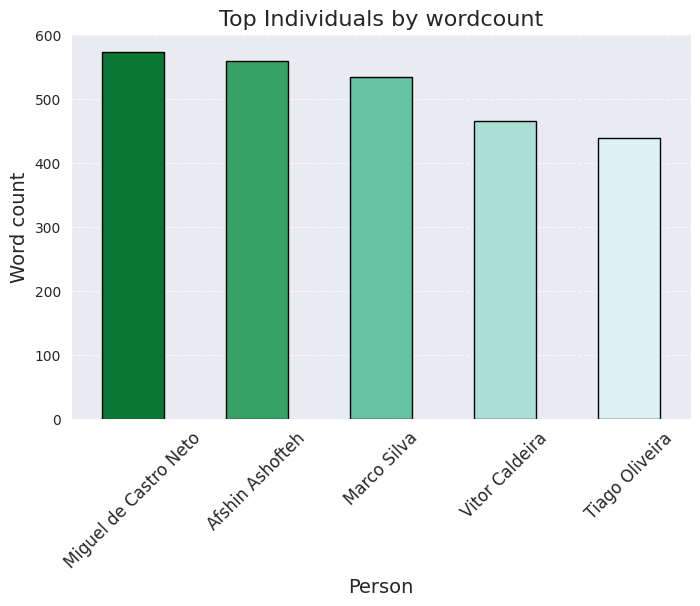

In [ ]:
# plotting a simple illustrative graph

plt.figure(figsize=(8, 5))
colors1 = list(reversed(sns.color_palette("BuGn", len(top_wordcounts))))
top_wordcounts.plot(kind='bar', color=colors1, edgecolor='black')
plt.title('Top Individuals by wordcount', fontsize=16)
plt.xlabel('Person', fontsize=14)
plt.ylabel('Word count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**2. (b) Who's the teacher with the highest coursecount?**

`Answer`

In [ ]:
dataset_p['Course Count'] = dataset_p['Courses'].apply(lambda x: len(str(x).split(', ')))  # creating a new column 'Course Count' by counting the number of courses each teacher teaches (split by commas)

highest_coursecount_row = dataset_p.loc[dataset_p['Course Count'].idxmax()]  # finding the row with the highest course count by getting the index of the maximum 'Course Count'

teacher_name = highest_coursecount_row['Name']  # extracting the name of the teacher with the highest course count
highest_coursecount = highest_coursecount_row['Course Count']  # extracting the number of courses taught by the teacher

print(f"The teacher with the highest course count is {teacher_name} with {highest_coursecount} courses.")  # printing the teacher's name and their course count


The teacher with the highest course count is Joana Neves with 16 courses.


`Graph visualization`

In [ ]:
person_course_counts = dataset_p.groupby('Name')['Course Count'].sum()  # grouping the dataset by teacher name and summing their total course counts
top_persons = person_course_counts.sort_values(ascending=False).head(5) # sorting the total course counts in descending order and selecting the top 5 teachers

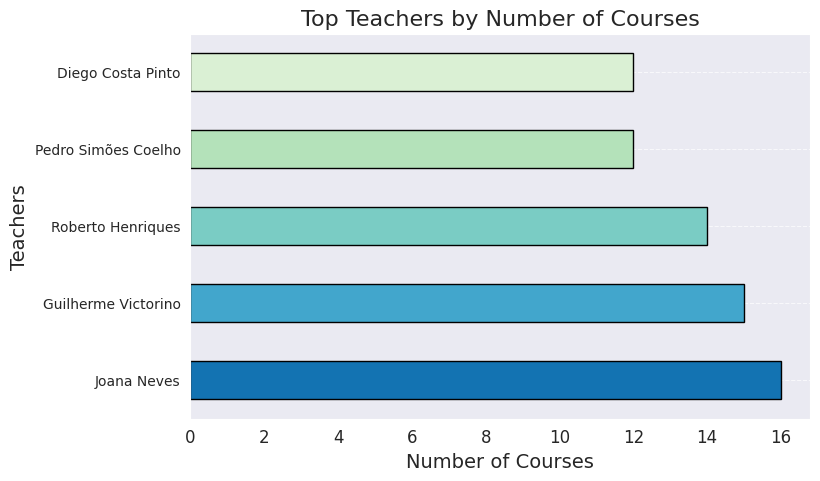

In [ ]:
#plotting a simple illustrative graph
plt.figure(figsize=(8, 5))
colors2 = list(reversed(sns.color_palette("GnBu", len(top_persons))))
top_persons.plot(kind='barh', color=colors2, edgecolor='black')
plt.title('Top Teachers by Number of Courses', fontsize=16)
plt.ylabel('Teachers', fontsize=14)
plt.xlabel('Number of Courses', fontsize=14)
plt.xticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**2. (c) Who's the teacher with the most publications?**

`Answer`

In [ ]:
most_publications_row = dataset_p.loc[dataset_p['Publications'].idxmax()]  # finding the row with the highest number of publications by getting the index of the maximum 'publications'

teacher_name = most_publications_row['Name']  # extracting the name of the teacher with the most publications
most_publications = most_publications_row['Publications']  # extracting the number of publications for that teacher

print(f"the teacher with the most publications is {teacher_name} with {most_publications} publications.")  # printing the teacher's name and their publication count

the teacher with the most publications is Tiago Oliveira with 220 publications.


In [ ]:
person_publications = dataset_p.groupby('Name')['Publications'].sum()      # grouping the dataset by teacher name and summing their total publications
top_publishers = person_publications.sort_values(ascending=False).head(5)  # sorting the total publications in descending order and selecting the top 5 teachers with the most publications


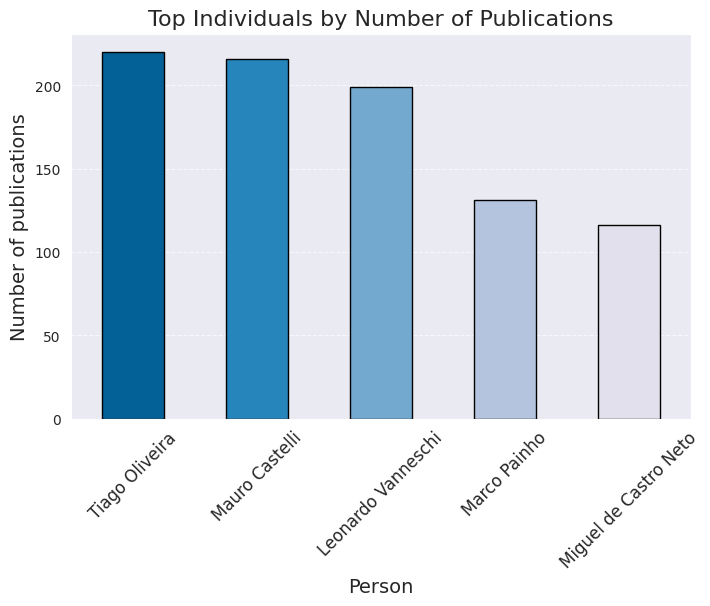

In [ ]:
#plotting a simple illustrative graph
plt.figure(figsize=(8, 5))
colors3 = list(reversed(sns.color_palette("PuBu", len(top_publishers))))
top_publishers.plot(kind='bar', color=colors3, edgecolor='black')
plt.title('Top Individuals by Number of Publications', fontsize=16)
plt.xlabel('Person', fontsize=14)
plt.ylabel('Number of publications', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**3. (a) How are the wordcount, coursecount and publications distributed and related?**

`Answer with graph visualization`

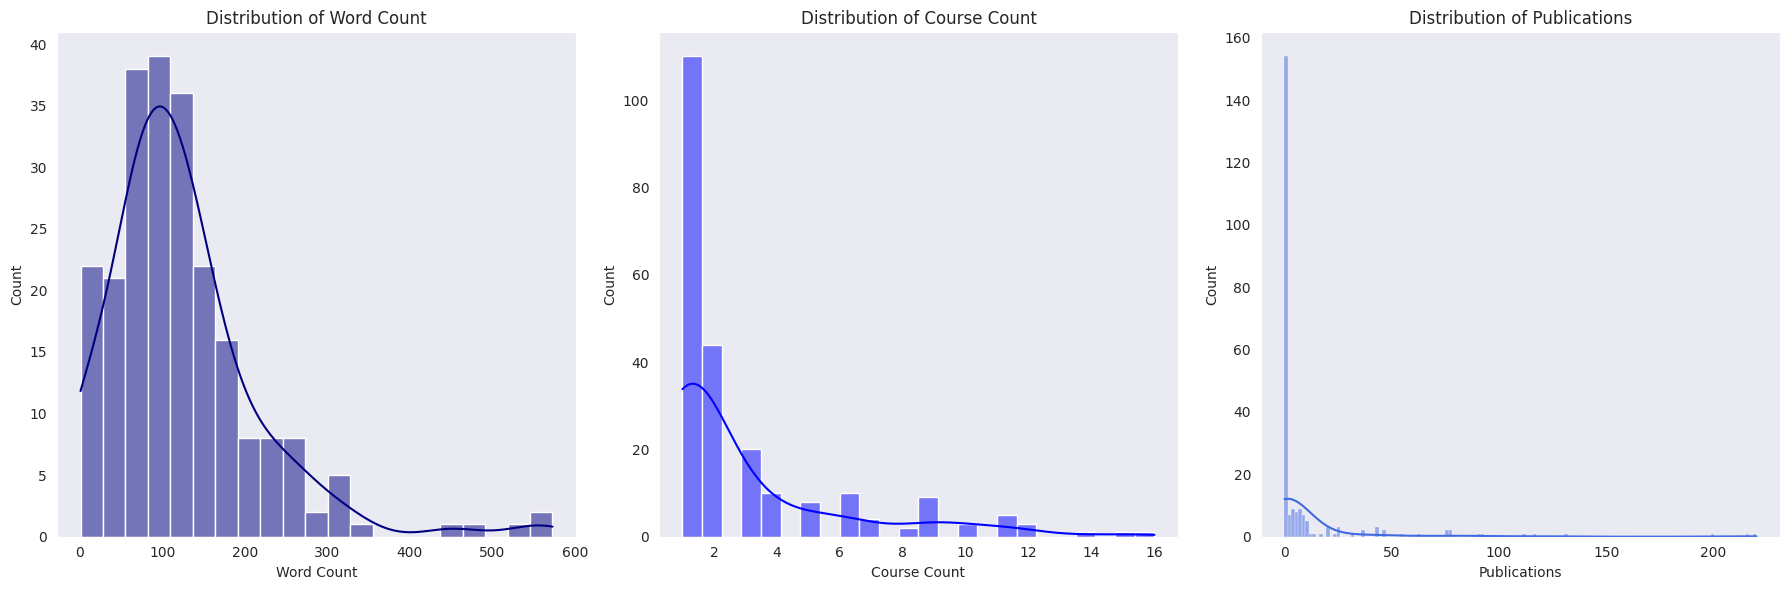

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(dataset_p['Word Count'], kde=True, ax=axes[0], color='navy')  # creating a histogram with a kernel density estimate (KDE) for 'word count' on the first subplot (axes[0])
axes[0].set_title('Distribution of Word Count')  # setting the title for the first subplot
axes[0].set_xlabel('Word Count')  # setting the x-axis label for the first subplot

sns.histplot(dataset_p['Course Count'], kde=True, ax=axes[1], color='blue')  # creating a histogram with a KDE for 'course count' on the second subplot (axes[1])
axes[1].set_title('Distribution of Course Count')  # setting the title for the second subplot
axes[1].set_xlabel('Course Count')  # setting the x-axis label for the second subplot

sns.histplot(dataset_p['Publications'], kde=True, ax=axes[2], color='royalblue')  # creating a histogram with a KDE for 'publications' on the third subplot (axes[2])
axes[2].set_title('Distribution of Publications')  # setting the title for the third subplot
axes[2].set_xlabel('Publications')  # setting the x-axis label for the third subplot

plt.tight_layout()
plt.show()

The analysis of the three graphs above allows us to understand the distrbution of the word, course, and publication counts. Firstly, in the first graph, we can see the most popular number of words per biography is around 100,

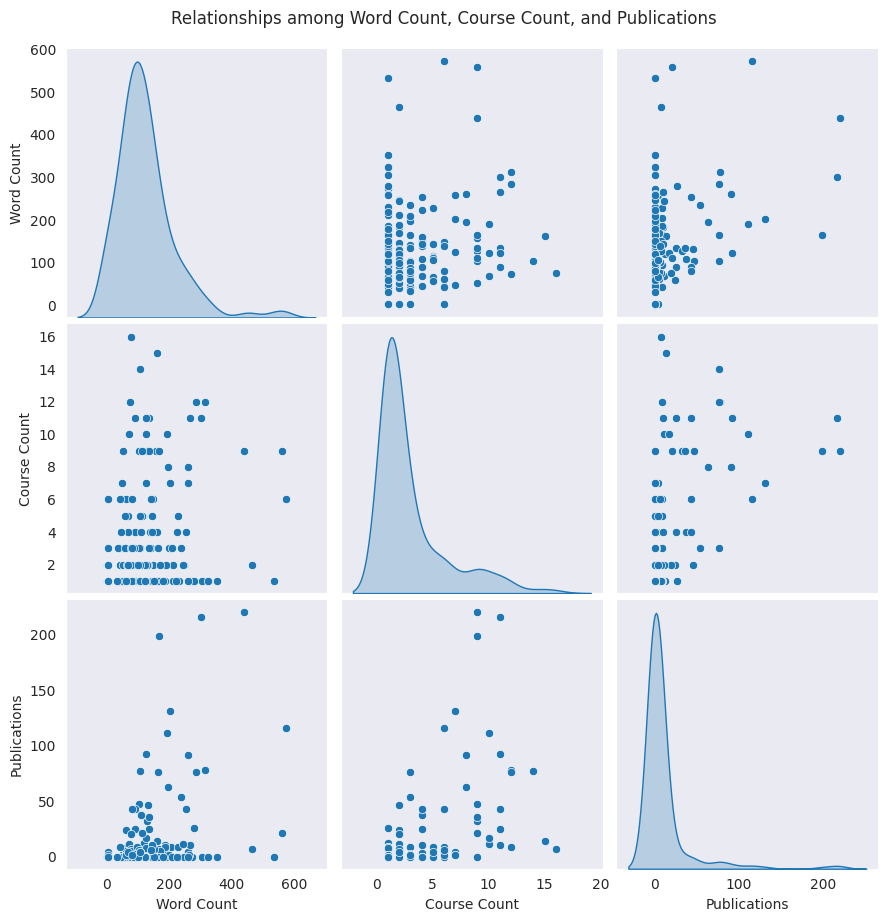

In [ ]:
sns.pairplot(dataset_p[['Word Count', 'Course Count', 'Publications']], diag_kind='kde', markers='o', height=3, palette='Purples')  # creating a pairplot to visualize relationships between 'word count', 'course count', and 'publications' with KDE on the diagonal and specified aesthetics
plt.suptitle("Relationships among Word Count, Course Count, and Publications", y=1.02)  # setting the title for the entire plot with an adjusted vertical position
plt.show()

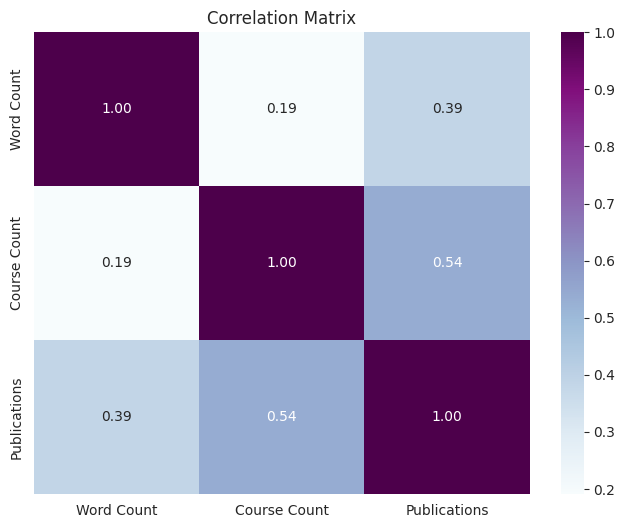

In [ ]:
correlation_matrix = dataset_p[['Word Count', 'Course Count', 'Publications']].corr()  # calculating the correlation matrix for 'word count', 'course count', and 'publications'

# creating a heatmap of the correlation matrix with annotations, 'BuPu' color palette, and formatting the values to two decimal places
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='BuPu', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

*The correlation matrix and pairplot reveal the relationships between the three counts. Course count and publications are slightly correlated, which implies that, in multiple cases, a teacher who teaches more courses has more publications, or vice versa. Word and publication counts show a small correlation as well, therefore there are some teachers with a higher/lower number of words in their biography because of a higher/lower number of publications, respectively. On the other hand, teachers dont seem to have more or less words in their biography based on how many or few courses they teach.*

**3. (b) Are there differences in those variables for different types of teachers?**

`Answer (with graph visualization)`

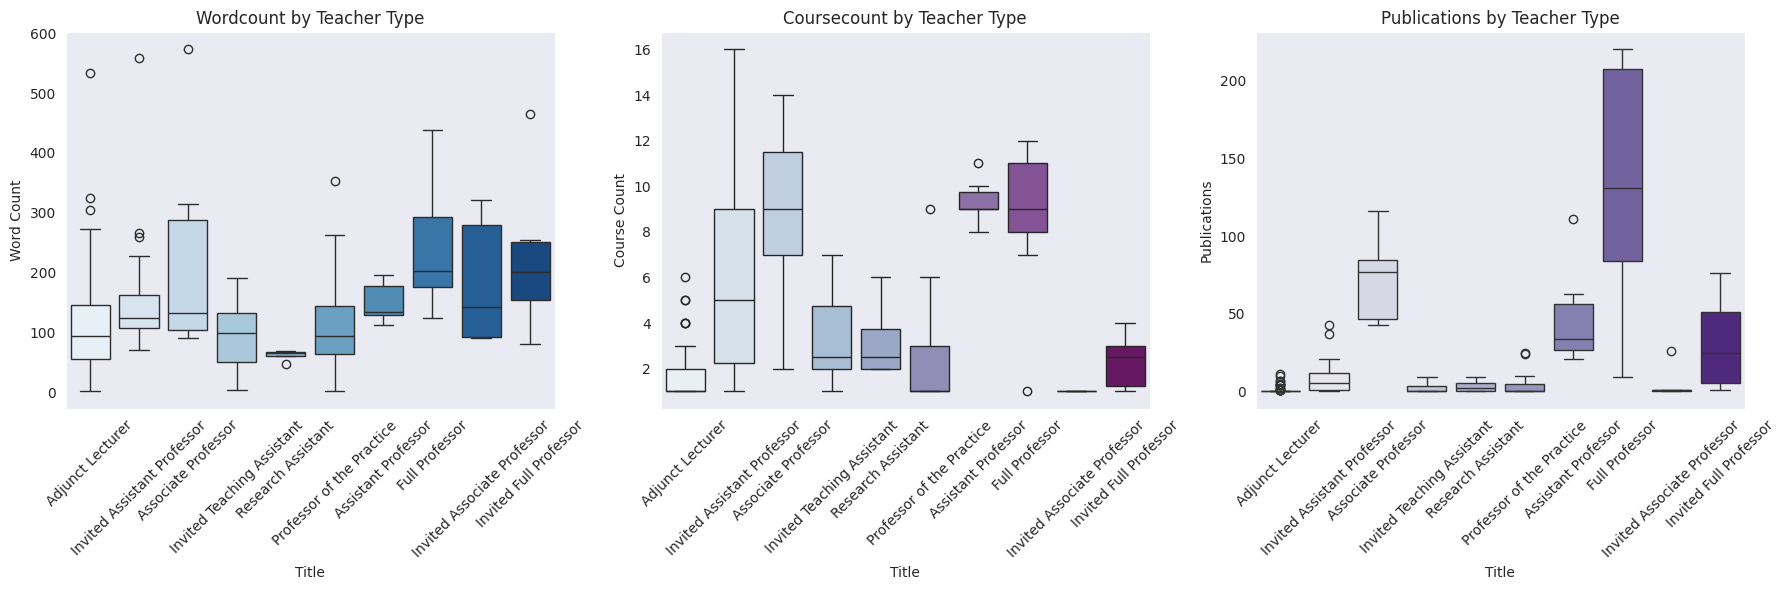

In [ ]:
# creating boxplots to visualize differences for each variable by TeacherType
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(x='Title', y='Word Count', data=dataset_p, ax=axes[0], palette="Blues")
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_title('Wordcount by Teacher Type')

sns.boxplot(x='Title', y='Course Count', data=dataset_p, ax=axes[1], palette="BuPu")
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_title('Coursecount by Teacher Type')

sns.boxplot(x='Title', y='Publications', data=dataset_p, ax=axes[2], palette="Purples")
axes[2].tick_params(axis='x', rotation=45)
axes[2].set_title('Publications by Teacher Type')

plt.tight_layout()
plt.show()


Yes, there are differences in those variables for different types of teachers.

**4. (a) How many different courses (unique course names) are taught at NOVA IMS?**

`Answer`

In [ ]:
unique_courses = dataset_p['Courses'].nunique()  # counting the number of unique courses in the 'Courses' column
print(f"There are {unique_courses} different courses taught at NOVA IMS.")

There are 191 different courses taught at NOVA IMS.


**4. (b) How many courses (unique course names) are taught by only one teacher?**


`Answer`

In [ ]:
course_teacher_counts = dataset_p.groupby('Courses')['Name'].nunique()  # grouping the dataset by 'Courses' and counting the number of unique teachers for each course
courses_taught_by_one_teacher = course_teacher_counts[course_teacher_counts == 1]  # filtering the courses where only one teacher is teaching them

print(f"The number of unique courses taught by only one teacher is {len(courses_taught_by_one_teacher)}.")

The number of unique courses taught by only one teacher is 165.


**4. (c) What's the probability of someone teaching 'Data Mining I' also teaching
‘Data Mining II'?**


`Answer`

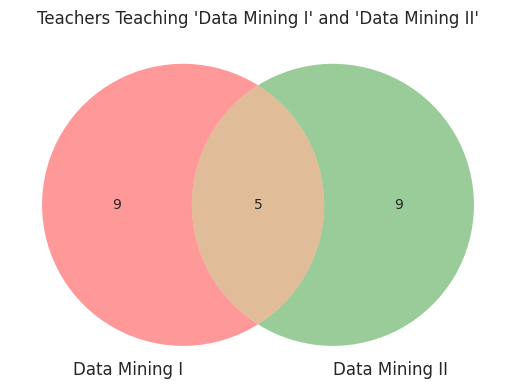

The probability of someone teaching 'Data Mining I' also teaching 'Data Mining II' is 0.5556.


In [ ]:
# getting the teachers teaching data mining 1 and data mining 2 respectively
teachers_data_mining_i = dataset_p[dataset_p['Courses'].str.contains('Data Mining I')]
teachers_data_mining_ii = dataset_p[dataset_p['Courses'].str.contains('Data Mining II')]

teachers_both_courses = pd.merge(teachers_data_mining_i, teachers_data_mining_ii, on='Name') # getting the teacher who teach both

num_teachers_both_courses = teachers_both_courses['Name'].nunique() # counting how many teach both

num_teachers_data_mining_i = teachers_data_mining_i['Name'].nunique() # counting how many teach only data mining 1
num_teachers_data_mining_ii = teachers_data_mining_i['Name'].nunique() # counting how many teach only data mining 2

probability = num_teachers_both_courses / num_teachers_data_mining_i # calculating the probability

# creating a venn diagram to better vizualize the probability
venn = venn2(
    subsets=(num_teachers_data_mining_i, num_teachers_data_mining_ii, num_teachers_both_courses),
    set_labels=('Data Mining I', 'Data Mining II')
)
plt.title("Teachers Teaching 'Data Mining I' and 'Data Mining II'")
plt.show()

print(f"The probability of someone teaching 'Data Mining I' also teaching 'Data Mining II' is {probability:.4f}.")

**5. (a) Insight 1**

In [ ]:
fig = px.scatter_3d(dataset_p,
                    x='Course Count',
                    y='Publications',
                    z='Word Count',
                    title='3D Scatter Plot of Course Count, Word Count, and Publications')

fig.show()

*For the first insight, we have created a 3d scatter plot that shows teacher's course counts, word counts, and number of publications. Upon some exploration and rotation of the graph, we can draw multiple conclusions: a higher number of publications usually implies a larger number of words in biography*

**5. (b) Insight 2**

In [ ]:
fig = px.box(dataset_p,
             x='Course Count',
             y='Publications',
             color='Title',
             title='Publications by Teacher Title and Course Count',
             labels={'Course Count': 'Number of Courses', 'Publications': 'Number of Publications'},
             points="all")
fig.show()

*For the second insight, which is highly correlated to the first one, we decided to further explore the course and publication count, but this time having in mind the teacher's title (which is usually time-correlated). In this violin plot, we can clearly see that Invited Assistant Professors, who are likely less experienced and have been teaching for less time, never have above 50 publications. However, they are pretty evenly distributed throughout the amount of courses taught. Invited Full Professors teach below 5 courses depite having a higher amount of publications. Full professors usually teach between 9 and 12 courses and have a high number of publications. Ajunct lecturers have a low count of both publications and courses.*

**5. (c) Insight 3**

In [ ]:
topnum = 10  # setting the number of top teachers to include in the network
min_co_teaching_count = 1  # minimum number of times teachers need to co-teach

dataset_p = dataset_p.assign(Course=dataset_p['Courses'].str.split(', ')).explode('Course')  # splitting the 'Courses' column into individual courses and expanding into separate rows

co_teacher_pairs = dataset_p.groupby('Course')['Name'].apply(lambda x: list(combinations(sorted(x), 2))).explode().reset_index(drop=True)  # finding pairs of co-teachers for each course

teacher_pair_counts = co_teacher_pairs.value_counts().reset_index()  # counting the frequency of each teacher pair
teacher_pair_counts.columns = ['Teacher Pair', 'Count']  # renaming the columns for clarity

teacher_pair_counts[['Teacher1', 'Teacher2']] = pd.DataFrame(  # separating the teacher pairs into two distinct columns
    teacher_pair_counts['Teacher Pair'].tolist(), index=teacher_pair_counts.index
)
teacher_pair_counts.drop(columns='Teacher Pair', inplace=True)  # removing the combined 'Teacher Pair' column

teacher_pair_counts = teacher_pair_counts[teacher_pair_counts['Count'] > min_co_teaching_count]  # filtering pairs that have a co-teaching count greater than the minimum threshold

top_teachers = pd.Series(dataset_p['Name'].value_counts()).head(topnum).index  # selecting the top 'n' teachers based on the number of courses taught
teacher_pair_counts = teacher_pair_counts[  # filtering pairs to include only those with top teachers
    teacher_pair_counts['Teacher1'].isin(top_teachers) &
    teacher_pair_counts['Teacher2'].isin(top_teachers)
]

G = nx.Graph()  # creating a new graph object for the teacher collaboration network

for _, row in teacher_pair_counts.iterrows():  # iterating through the teacher pairs and adding them as edges in the graph
    G.add_edge(row['Teacher1'], row['Teacher2'], weight=row['Count'])  # adding edges with the co-teaching count as the edge weight

pos = nx.spring_layout(G, seed=42)  # calculating the layout for the graph using a spring layout algorithm

fig = go.Figure()  # initializing a new figure for plotting

edge_x, edge_y, edge_weights = [], [], []  # initializing lists to store edge data for plotting
for edge in G.edges(data=True):  # iterating over the edges to get the positions and weights
    x0, y0 = pos[edge[0]]  # coordinates of the first node
    x1, y1 = pos[edge[1]]  # coordinates of the second node
    edge_x.extend([x0, x1])  # storing x-coordinates for the edge
    edge_y.extend([y0, y1])  # storing y-coordinates for the edge
    edge_weights.append(edge[2]['weight'])  # storing the weight (co-teaching count) of the edge

fig.add_trace(go.Scatter(  # plotting the edges of the network
    x=edge_x, y=edge_y,
    mode='lines',
    line=dict(width=1, color='blue'),
    hoverinfo='none'  # no hover information for edges
))

node_x, node_y, node_text = [], [], []  # initializing lists to store node data for plotting
for teacher in G.nodes():  # iterating over the nodes (teachers) in the network
    x, y = pos[teacher]  # getting the position of the teacher
    node_x.append(x)  # storing the x-coordinate of the node
    node_y.append(y)  # storing the y-coordinate of the node
    node_text.append(teacher)  # storing the teacher's name to display on hover

fig.add_trace(go.Scatter(  # plotting the nodes of the network
    x=node_x, y=node_y,
    mode='markers+text',
    marker=dict(size=12, color='orange'),
    text=node_text,
    textposition='top center',
    hoverinfo='text'  # showing the teacher's name on hover
))

fig.update_layout(  # updating the layout of the figure
    title='Teacher Collaboration Network (Co-teaching)',  # setting the title of the plot
    showlegend=False,  # hiding the legend
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=True),  # customizing x-axis appearance
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=True),  # customizing y-axis appearance
    height=600,  # setting the height of the plot
    width=800  # setting the width of the plot
)

fig.show()

*Lastly, the third insight shows a network of the top 10 teachers that collaborate the most, that is, the teachers that teach the same courses together.*

#Data Science in Action:

For this part of the project, we are going to perform a more in depth analysis of teachers' biographies, in particular through the creation of a document term matrix and subsequently word clouds, which will allow us to extract significant information regarding word distribution, such as finding out which words are the most commonly used for certain types of teacher.

*To begin this analysis, we have to preprocess each teacher's biography, which means that any special characters and stopwords should be removed and all words should be set to lowercase. To facilitate our work towards our goal, we are also going to group similar words together, in a process named lematization. It consists in taking a group of words, such as changing, changed, changes, and grouping them all into a single word - change. To make this possible, we are going to be using spaCy, a python library used for advanced Natural Language Processing (NLP), which perfectly fits our text processing needs.*



In [ ]:
dataset_p2= pd.read_csv('nova_ims_teaching_staff_2024-12-20.csv')

In [ ]:
nlp = spacy.load("en_core_web_sm") # loading spaCy model
stop_words = nlp.Defaults.stop_words  # using spaCy's built-in stopwords

def preprocess(text): # defining a text preprocessing funtion

    text = re.sub(r'\W', ' ', text)  # removing special characters
    text = text.lower()  # converting to lowercase
    tokens = nlp(text) # lemmatizing (grouping similar forms of the same word together)
    tokens = [token.lemma_ for token in tokens if token.text not in stop_words and not token.is_punct] # removing stopwords by comparing them with spaCy's built-in stopwords
    return " ".join(tokens) # joining all words into a string

dataset_p2['cleaned_biography'] = dataset_p2['Biography'].apply(lambda x: preprocess(str(x))) # applying the preprocessing fucntion to the biographies

*The next step in our analysis is to convert the text data into a format that can be easily analysed by machine learning models. To do so, we will start by constructing a document-term matrix (DTM), which will represent the frequency with which words appear across all biographies. This matrix is essential for performing topic modeling, a technique used to identify patterns or topics within a set of text documents. With this matrix, we will be able to start performing topic modelling, that is, identifying patterns within the biogrphies.*

*The sklearn library has an available CountVectorizer, which will help us convert text into a matrix where each row corresponds to a biography and each column represents a term/word. We will fine tune the parameters to make sure that: terms that appear in more than 90% of the biographies or in less than 5 biographies are excluded, due to lack of meaning; common stop words such as "the", "and" are removed for the same reason.*

*Once we have the document-term matrix, we can apply a topic modeling technique: Latent Dirichlet Allocation, a statistical model used to discover the underlying topics in a collection of documents. In our case, by specifying that we want to extract 5 topics from our text data and fitting the LDA model on the document-term matrix, the algorithm will learn to identify groups of words that frequently occur together, creating 5 different topics, each with a list of words associated to it.*

In [ ]:
# converting text to document-term matrix
vectorizer = CountVectorizer(max_df=0.9, min_df=5, stop_words='english')  # initializing the CountVectorizer to convert text into a document-term matrix with specific settings
doc_term_matrix = vectorizer.fit_transform(dataset_p2['cleaned_biography'])  # fitting the vectorizer on the cleaned biography text and transforming it into a document-term matrix

n_topics = 5  # setting the number of topics for topic modeling
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)  # initializing the LDA model with the specified number of topics and a fixed random state for reproducibility
lda.fit(doc_term_matrix)  # fitting the LDA model on the document-term matrix to extract topics

LatentDirichletAllocation(n_components=5, random_state=42)

*Now that we have created 5 topics, we can start by displaying the words associated to each of them:*

In [ ]:
print("Top Words for Each Topic:")  # displaying the header for the top words of each topic
for i, topic in enumerate(lda.components_):  # iterating over each topic in the LDA model
    top_words = [vectorizer.get_feature_names_out()[j] for j in topic.argsort()[-10:]]  # getting the top 10 words for each topic by sorting the topic's word distribution
    print(f"Topic {i+1}: {', '.join(top_words)}")  # printing the top 10 words for the current topic

Top Words for Each Topic:
Topic 1: research, science, business, master, im, datum, degree, nova, information, management
Topic 2: project, include, business, economic, digital, university, international, work, research, marketing
Topic 3: information, management, national, research, statistical, international, economic, university, nova, statistic
Topic 4: national, lisbon, work, public, management, degree, director, university, financial, finance
Topic 5: member, strategy, experience, management, year, marketing, digital, available, soon, information


*Let's analyse each topic and the words associated with it:*

***Topic 1*** *is centered on academic research, business, and data management in the context of science and higher education.*

***Topic 2*** *is focused on international projects, economics, and digital marketing in business and university settings.*

***Topic 3*** *is more about statistical research, economics, and information management with both national and international perspectives.*

***Topic 4*** *is centered on public sector management, finance, and leadership roles, it is possibly related to public administration and finance.*

***Topic 5*** *is more about business strategy, digital marketing, and team experience, focusing on planning and information sharing.*

*To allow simple visualization of the previous results, we can create a wordcloud for each of our topics:*

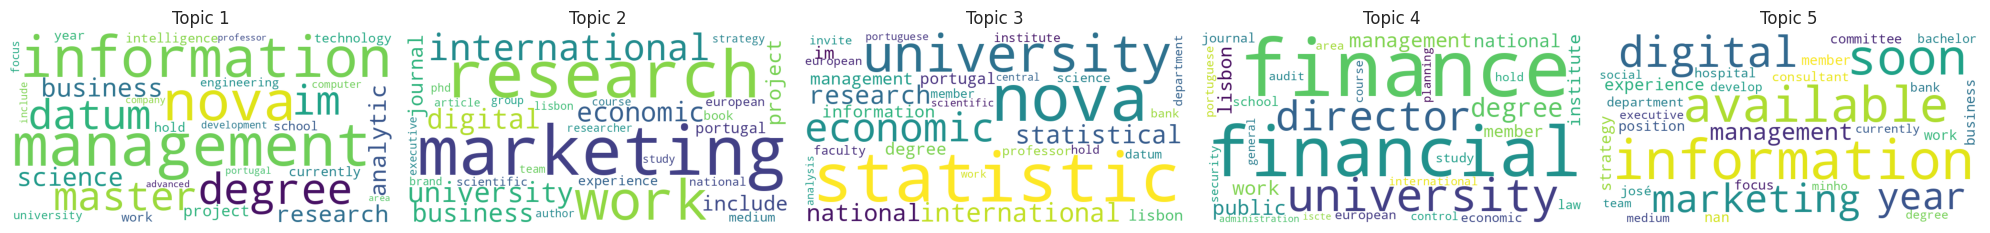

In [ ]:
# creating word clouds for each topic
fig, axes = plt.subplots(1, n_topics, figsize=(20, 8), sharey=True)
for i, topic in enumerate(lda.components_):
    word_freqs = {vectorizer.get_feature_names_out()[j]: topic[j] for j in topic.argsort()[-30:]}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freqs)
    axes[i].imshow(wordcloud)
    axes[i].axis("off")
    axes[i].set_title(f"Topic {i+1}")
plt.tight_layout()
plt.show()

*Lastly, let's work with our topics and derive some interesting information about their underlying distribution with the help of some graphic visualizations:*

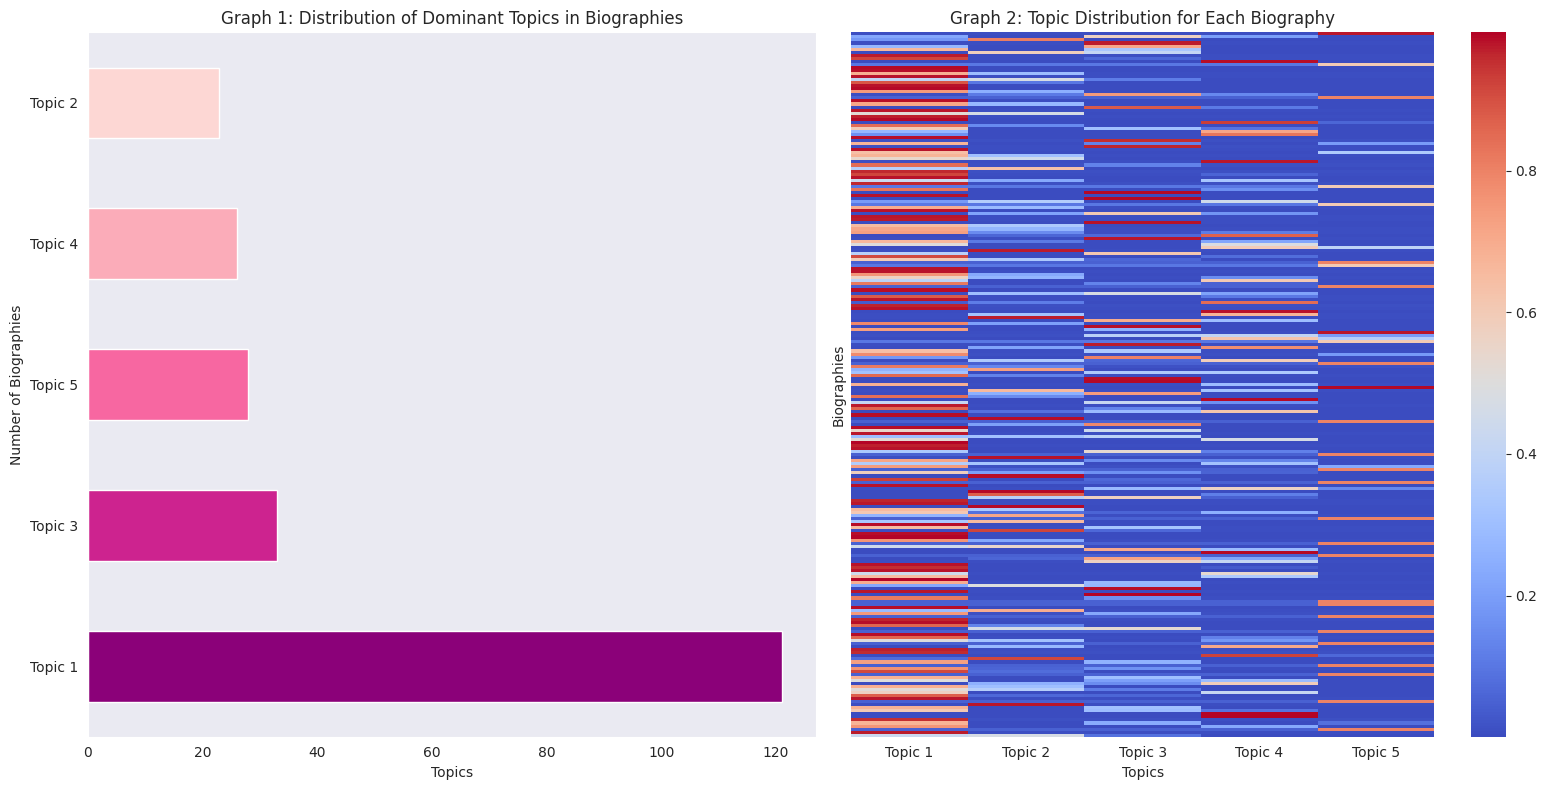

'topic_proportions = topic_distribution.mean(axis=0) # calculating the average proportion of each topic across all biographies\n\n# plotting a bar chart for visualization\nplt.figure(figsize=(8, 5))\ncolors5 = list(reversed(sns.color_palette("PuRd", n_topics)))\nplt.bar(range(1, n_topics + 1), topic_proportions, color=colors5)\nplt.title("Graph 3: Average Topic Proportions Across Biographies")\nplt.xlabel("Topic Number")\nplt.ylabel("Average Proportion")\nplt.xticks(range(1, n_topics + 1))\nplt.show()'

In [ ]:
# computing topic distribution for each biography
topic_distribution = lda.transform(doc_term_matrix)  # applying the LDA model to the document-term matrix to compute topic distribution for each biography
topic_df = pd.DataFrame(topic_distribution, columns=[f"Topic {i+1}" for i in range(n_topics)])  # creating a DataFrame where each row represents a biography and each column represents a topic with the topic's distribution
data_with_topics = pd.concat([dataset_p2, topic_df], axis=1)  # concatenating the original dataset with the topic distribution DataFrame along columns

data_with_topics['Dominant Topic'] = topic_df.idxmax(axis=1)  # determining the dominant topic for each biography by selecting the topic with the highest distribution score
topic_counts = data_with_topics['Dominant Topic'].value_counts() # counting how many biographies are associated with each dominant topic

# creating a graph visualization (bar plot and heatmap)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
colors4 = list(reversed(sns.color_palette("RdPu", n_topics)))
topic_counts.plot(kind='barh', color=colors4, ax=axes[0])
axes[0].set_title("Graph 1: Distribution of Dominant Topics in Biographies")
axes[0].set_xlabel("Topics")
axes[0].set_ylabel("Number of Biographies")
axes[0].tick_params(axis='x', rotation=0)

sns.heatmap(topic_df, cmap="coolwarm", cbar=True, xticklabels=True, yticklabels=False, ax=axes[1])
axes[1].set_title("Graph 2: Topic Distribution for Each Biography")
axes[1].set_xlabel("Topics")
axes[1].set_ylabel("Biographies")

plt.tight_layout()
plt.show()

*The topic number 1 is, most definitely, the most common one, which is made very clear from the analysis of Graph 1 (the topic 1 bar is, by far, the longest), Graph 2 (topic 1 is present in most biographies). As seen previously, this may be due to the fact that this topic is the broadest one. Since all teachers are in the same university, the subjects they teach, as well as their academic formation will all be very similar, therefore their biographies are very likely to have a similar structure, which will especially contain these broader terms. According to Graphs 1 and 2, the remaining topics seem to be very uniformly dispersed through the biographies, with Topic 3 being the second most popular, followed by topic 5, 4 and 2, respectively.*

<Figure size 1000x600 with 0 Axes>

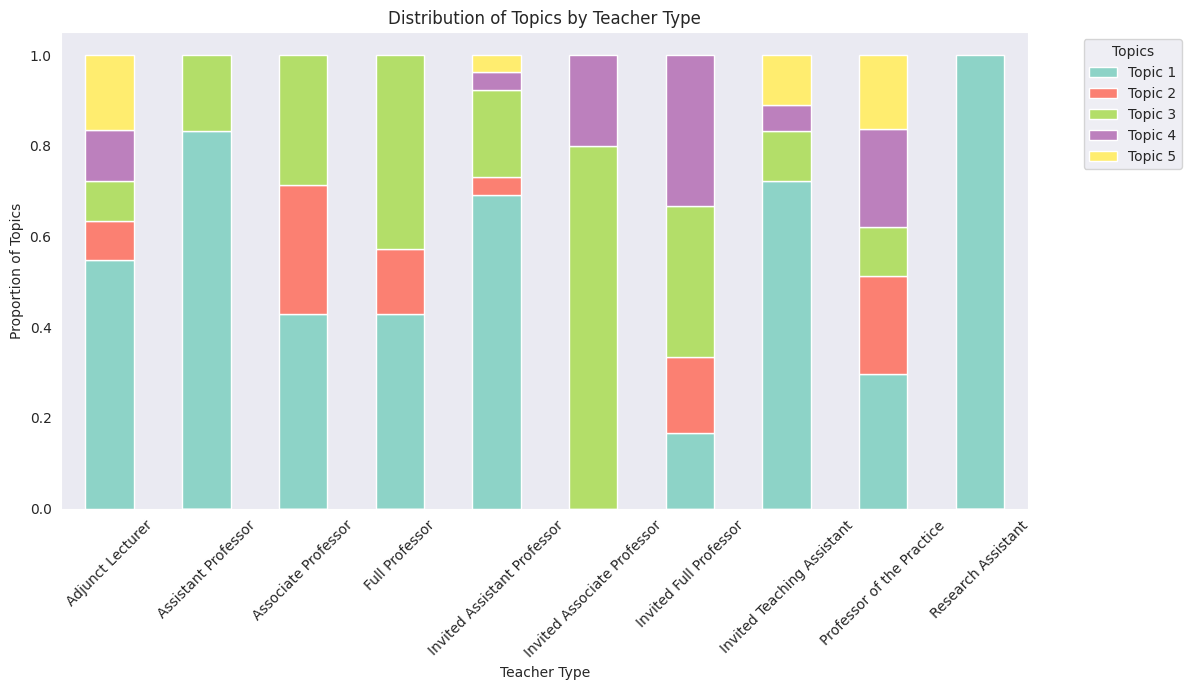

In [ ]:
# calculating topic distribution by teacher type
topic_by_teacher_type = data_with_topics.groupby('Title')['Dominant Topic'].value_counts().unstack(fill_value=0)

# normalizing the counts to show proportions instead of counts
topic_by_teacher_type_normalized = topic_by_teacher_type.div(topic_by_teacher_type.sum(axis=1), axis=0)

# plotting the distribution of topics by teacher type
plt.figure(figsize=(10, 6))
topic_by_teacher_type_normalized.plot(kind='bar', stacked=True, colormap='Set3', figsize=(12, 7))

plt.title("Distribution of Topics by Teacher Type")
plt.xlabel("Teacher Type")
plt.ylabel("Proportion of Topics")
plt.xticks(rotation=45)
plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

*This distribution of biography topics based on the teacher's title show that there actually is a big variation in the prominence of topics amongst teachers' biographies. We can see that Topic 1 dominates in titles like research assistant and adjunct lecturer. Similarly to those two teacher titles, Invited Associate Professors seem to be the ones with the least overall topic use in their biographies. On the other hand, Professors of the Practice and Adjunct Lecturers explore all topics. The higher the teacher's status is (typically full professors), the more topics are typically used.*

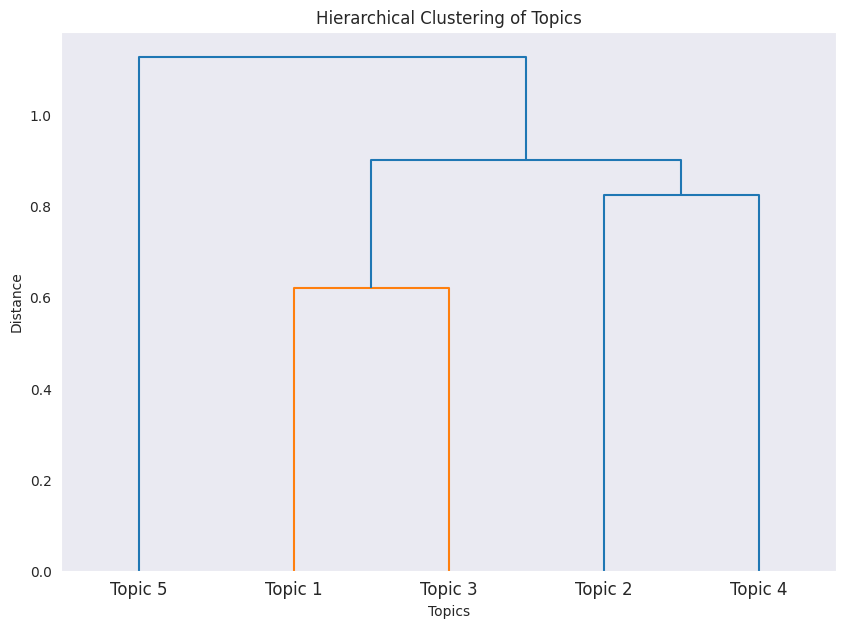

In [ ]:
# computing pairwise distance between topic distributions
distances = cdist(lda.components_, lda.components_, metric='cosine')  # calculating the cosine distances between the topic-word distributions (lda.components_) using the cdist function
linkage_matrix = linkage(distances, 'ward')  # applying hierarchical clustering (ward linkage) to the cosine distances to create a linkage matrix for dendrogram visualization

# plotting a dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=[f"Topic {i+1}" for i in range(n_topics)], orientation='top')
plt.title("Hierarchical Clustering of Topics")
plt.xlabel("Topics")
plt.ylabel("Distance")
plt.show()

*When analysing a dendogram (a tree like diagram that helps visualize the arrangement of clusters based on their similarites), the height of the branches is the most important thing to take into consideration. The lower the merge height of two topics is, the more similar they will be. In this case, topic 5 stands out as being the most distinct one, merging with the other topics at the highest distance; topics 2 and 4 are relatively different as well but merge with other topics at a lower height than topic 5; topics 1 and 3 are ultimately the most similar since they have the lowest merging height.*

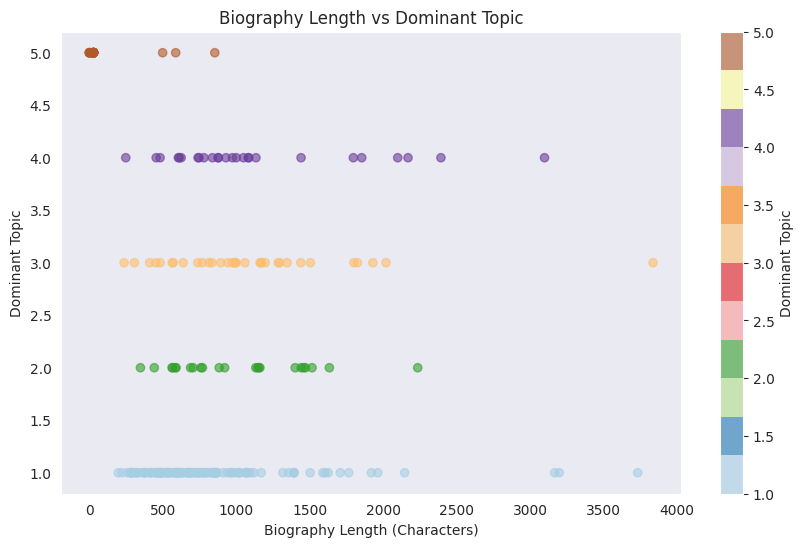

In [ ]:
# cleaning up dominant topic to ensure it's numeric (if dominant topic is still a string like 'Topic 5', we need to extract the number part)
data_with_topics['Dominant Topic'] = data_with_topics['Dominant Topic'].str.extract('(\d+)').astype(int)

# ensuring biography length is calculated correctly and missing values are handled
data_with_topics['Biography Length'] = dataset_p2['Biography'].fillna("").apply(len)

# creating a scatterplot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    data_with_topics['Biography Length'],
    data_with_topics['Dominant Topic'],
    c=data_with_topics['Dominant Topic'],
    cmap='Paired',
    alpha=0.6
)

# adding colorbar to show the mapping of colors to topics
plt.colorbar(scatter, label="Dominant Topic")

# setting titles and labels
plt.title("Biography Length vs Dominant Topic")
plt.xlabel("Biography Length (Characters)")
plt.ylabel("Dominant Topic")
plt.show()

ANALYSIS TEXT